In [42]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_distances
from numpy import dot
from numpy.linalg import norm
import torch
import transformers as ppb
import warnings
import random
import matplotlib.pyplot as plt
from os import walk
from itertools import permutations
import pickle
import time

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [87]:
def data2df(PATH):
    lines = open(PATH, encoding='iso-8859-1').read().strip().split('\n')
    lines = [line.split("\t") for line in lines]
    lines = pd.DataFrame(lines)
    lines = lines[lines[1] != 'UNCONFIDENT_INTENT_FROM_SLAD']
    lines[1] = lines[1].apply(lambda x: int(x)-1)
    return lines

def df2embd(df):
    max_row = min(len(df[df[1]==1]),len(df[df[1]==0]),1000)
    batch_1 = pd.concat((df[df[1]==1].sample(n=max_row, random_state=1),df[df[1]==0].sample(n=max_row, random_state=1)))
    tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    features = last_hidden_states[0][:,0,:].numpy()
    labels = batch_1[1]
    return features, np.array(labels)

def cos_dist(A, B):
       return 1 - (dot(A, B)/(norm(A)*norm(B)))

def S2T(train_features, train_labels, test_features, test_labels):
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    return lr_clf.score(test_features, test_labels)


def S2ti(train_features, train_labels, test_features, test_labels, num_i, eval_bool = False, dist_eval = False):
    source_center = np.mean(train_features,axis = 0)
    target_distances = [cos_dist(source_center, x) for x in test_features]
    
    if eval_bool:
        print("train.shape: ",train_labels.shape)
        print("test.shape: ",test_labels.shape) 
        print("histogram of distance:")
        plt.hist(target_distances)
        plt.show()
    
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    
    # dividing data
    threshold = int(len(target_distances)/num_i)
    targets = []
    targets.append(target_distances[:threshold])
    for i in range(1,num_i-1):
        targets.append(target_distances[i*threshold:(i+1)*threshold])
    targets.append(target_distances[(num_i-1)*threshold:])
    
    # calculate influence of distribution 
    if dist_eval:
        targets_center = []
        distribution = []
        for target in targets:
            X_test = [test_features[i] for i,x in target]
            targets_center.append(np.mean(X_test,axis = 0))
        distribution.append(cos_dist(source_center, targets_center[0]))
        for i in range(len(targets_center)-1):
            distribution.append(cos_dist(targets_center[i], targets_center[i+1]))
    
    
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in targets:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression()
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    
    if dist_eval:
        return original_score, gradual_score, distribution
    else:
        return original_score, gradual_score

def all_combination_test(num_i, dist_eval = False):
    data_permu = list(permutations(all_data,2))
    S2T_scores = []
    S2ti_scores = []
    dist_list = []
    for permu in data_permu:
        if dist_eval:
            S2T_scr, S2ti_scr, dist = S2ti(permu[0][0], permu[0][1], permu[1][0], permu[1][1],num_i,dist_eval = dist_eval)
            dist_list.append(dist)
        else:
            S2T_scr, S2ti_scr = S2ti(permu[0][0], permu[0][1], permu[1][0], permu[1][1],num_i,dist_eval = dist_eval)
        S2T_scores.append(S2T_scr)
        S2ti_scores.append(S2ti_scr)
        
    
    iterative_scores = [S2ti_scores[i] - S2T_scores[i] for i in range(len(S2ti_scores))]
    if dist_eval:
        return iterative_scores,S2T_scores,S2ti_scores, dist_list
    else:
        return iterative_scores,S2T_scores,S2ti_scores
    


In [ ]:
df_train = data2df('/content/data/amazon_review/train/Apps_for_Android.train')
df_test = data2df('/content/data/amazon_review/test/Baby.test')
print(df_train.shape)
print(df_test.shape)
max_row = min(len(df_train[df_train[1]==1]),len(df_train[df_train[1]==0]),1000)
print(max_row)

(403520, 2)
(200, 2)
1000


In [ ]:
train_features, train_labels = df2embd(df_train)

In [ ]:
test_features, test_labels = df2embd(df_test)

In [ ]:
# Apps_for_Android
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.91

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Beauty.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.89

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Books.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.85

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/CDs_and_Vinyl.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.875

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Cell_Phones_and_Accessories.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.91

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Clothing_Shoes_and_Jewelry.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.875

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Electronics.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.885

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Health_and_Personal_Care.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.865

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Home_and_Kitchen.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.87

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Kindle_Store.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/test/Baby.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.885

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/test/Baby.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(train_features, train_labels)

0.99

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Cell_Phones_and_Accessories.train'))
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(train_features, train_labels)

0.95

# S -> t1, t2, t3, t4, t5

In [ ]:
train_features, train_labels = df2embd(data2df('/content/data/amazon_review/train/Apps_for_Android.train'))
test_features, test_labels = df2embd(data2df('/content/data/amazon_review/train/Beauty.train'))

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


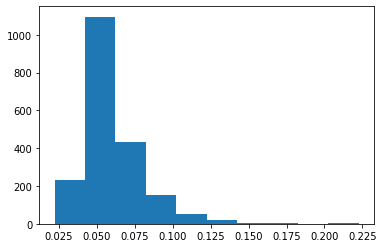

(0.9, 0.9045)

In [ ]:
S2ti(train_features, train_labels, test_features, test_labels)

In [ ]:
book_features, book_labels = df2embd(data2df('/content/data/amazon_review/train/Books.train'))

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


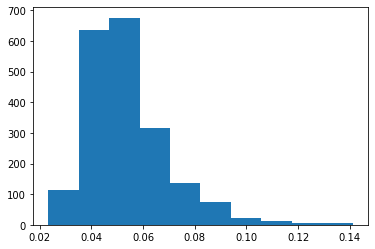

(0.881, 0.8985)

In [ ]:
S2ti(train_features, train_labels, book_features, book_labels)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


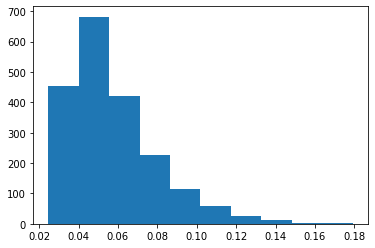

(0.892, 0.897)

In [ ]:
S2ti(book_features, book_labels,train_features, train_labels)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


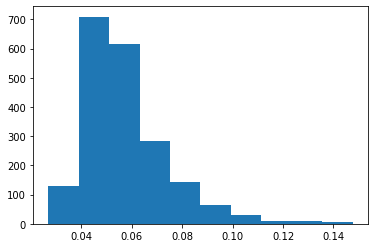

(0.9075, 0.9075)

In [ ]:
S2ti(test_features, test_labels, book_features, book_labels)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


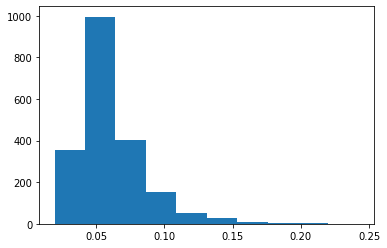

(0.8605, 0.861)

In [ ]:
S2ti(book_features, book_labels,test_features, test_labels)

In [ ]:
elec_features, elec_labels = df2embd(data2df('/content/data/amazon_review/train/Electronics.train'))

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


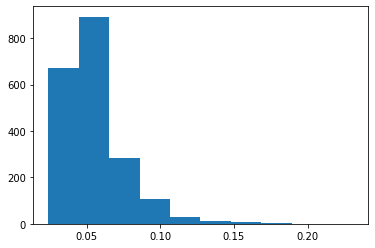

(0.862, 0.869)

In [ ]:
S2ti(train_features, train_labels, elec_features, elec_labels)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


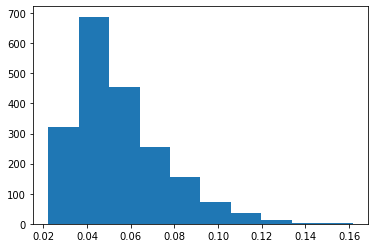

(0.8925, 0.897)

In [ ]:
S2ti(elec_features, elec_labels, train_features, train_labels)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


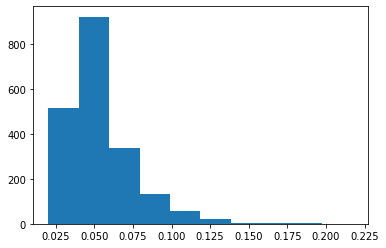

(0.9045, 0.906)

In [ ]:
S2ti(elec_features, elec_labels,test_features, test_labels)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


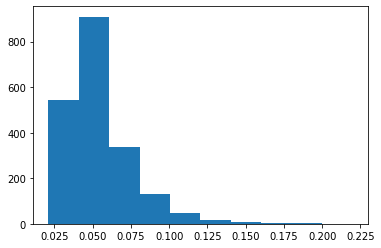

(0.893, 0.8975)

In [ ]:
S2ti(test_features, test_labels,elec_features, elec_labels)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


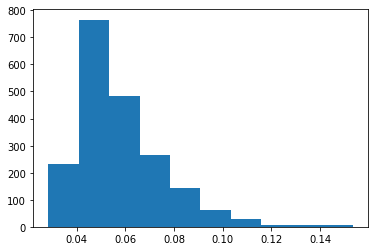

(0.8625, 0.8725)

In [ ]:
S2ti(elec_features, elec_labels,book_features, book_labels)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


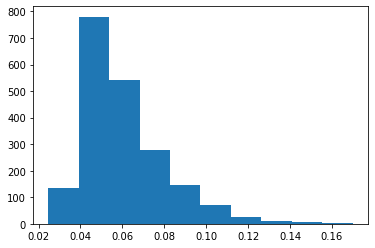

(0.8835, 0.8815)

In [ ]:
S2ti(test_features, test_labels, train_features, train_labels)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


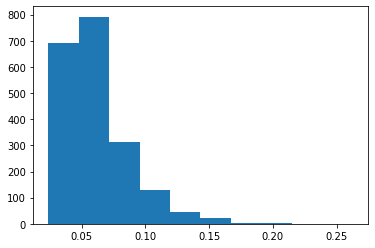

(0.8215, 0.819)

In [ ]:
S2ti(book_features, book_labels, elec_features, elec_labels)

# iterative calculation

In [9]:
_, _, filenames = next(walk('./data/amazon_review/train/'))
filenames = [x for x in filenames if x[-6:] == ".train"]

In [11]:
all_data = [df2embd(data2df('./data/amazon_review/train/' + x))+(x,) for x in filenames]

In [24]:
## Save pickle
with open("./data/amazon_review/data.pickle","wb") as fw:
    pickle.dump(all_data, fw)

# Load pickle
# with open("data.pickle","rb") as fr:
#     data = pickle.load(fr)



In [41]:
iterative_scores_5,S2T_scores_5,S2ti_scores_5 = all_combination_test(5)

In [44]:
%%notify
iterative_scores_5 = iterative_scores
S2T_scores_5 = S2T_scores
S2ti_scores_5 = S2ti_scores

<IPython.core.display.Javascript object>

In [45]:
np.mean(iterative_scores_5)

0.0025179296775831475

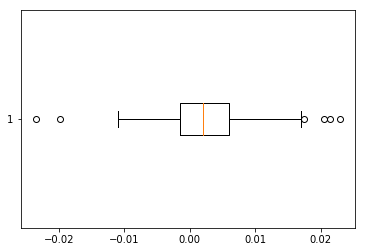

In [46]:
plt.boxplot(iterative_scores_5,vert=False)
plt.show()

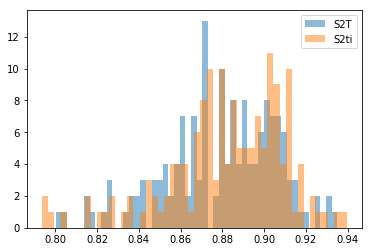

In [47]:
bins = 50
plt.hist(S2T_scores_5, bins, alpha=0.5, label='S2T')
plt.hist(S2ti_scores_5, bins, alpha=0.5, label='S2ti')
plt.legend(loc='upper right')
plt.show()

In [36]:
iterative_scores_10,S2T_scores_10,S2ti_scores_10 = all_combination_test(10)

In [38]:
np.mean(iterative_scores_10)

0.0024944888719641224

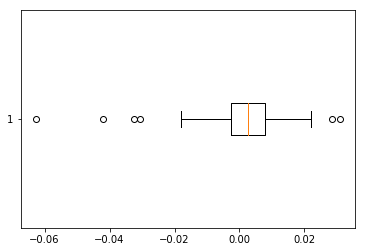

In [39]:
plt.boxplot(iterative_scores_10,vert=False)
plt.show()

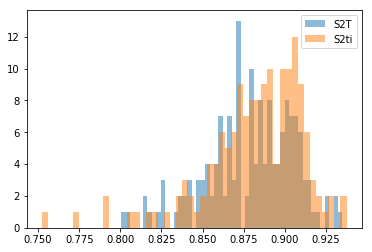

In [40]:
bins = 50
plt.hist(S2T_scores_10, bins, alpha=0.5, label='S2T')
plt.hist(S2ti_scores_10, bins, alpha=0.5, label='S2ti')
plt.legend(loc='upper right')
plt.show()

In [58]:
%%notify
iterative_scores_20,S2T_scores_20,S2ti_scores_20 = all_combination_test(20)

<IPython.core.display.Javascript object>

In [59]:
np.mean(iterative_scores_20)

0.0027050753152238296

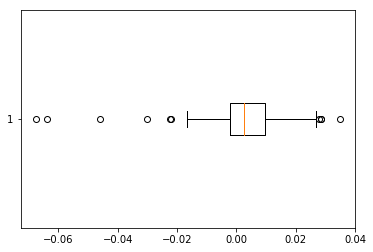

In [60]:
plt.boxplot(iterative_scores_20,vert=False)
plt.show()

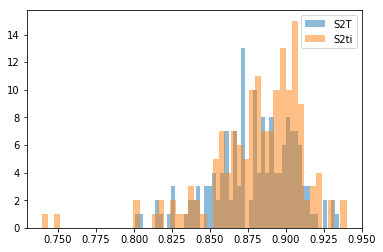

In [61]:
bins = 50
plt.hist(S2T_scores_20, bins, alpha=0.5, label='S2T')
plt.hist(S2ti_scores_20, bins, alpha=0.5, label='S2ti')
plt.legend(loc='upper right')
plt.show()

## why some data is less than 0.8?

In [64]:
[i for i,x in enumerate(S2ti_scores_10) if x<0.8]

[68, 70, 128, 129]

In [63]:
[i for i,x in enumerate(S2ti_scores_20) if x<0.8]

[68, 70]

In [66]:
np.mean([x for i,x in enumerate(iterative_scores_20) if i not in [68,70]])

0.0035951202263083443

In [73]:
data_names = [all_data[x][2] for x in range(len(all_data))]
names_permu = list(permutations(data_names,2))
print(names_permu[68])
print(data_names.index(names_permu[68][0]),data_names.index(names_permu[68][1]))
print(names_permu[70])
print(data_names.index(names_permu[70][0]),data_names.index(names_permu[70][1]))

('Movies_and_TV.train', 'Office_Products.train')
5 9
('Movies_and_TV.train', 'Health_and_Personal_Care.train')
5 11


train.shape:  (2000,)
test.shape:  (606,)
histogram of distance:


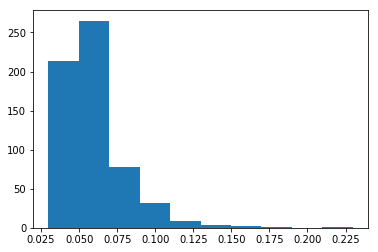

(0.8151815181518152, 0.7475247524752475)

In [75]:
S2ti(all_data[5][0], all_data[5][1],all_data[9][0], all_data[9][1], 20, eval_bool = True)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


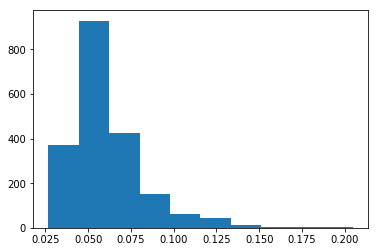

(0.8035, 0.7395)

In [79]:
S2ti(all_data[5][0], all_data[5][1],all_data[11][0], all_data[11][1], 20, eval_bool = True, dist_eval = True)

# check distribution

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


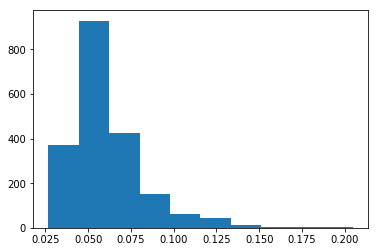

(0.8035,
 0.7395,
 [0.013696432113647461,
  0.0009578466415405273,
  0.0006793737411499023,
  0.0006948113441467285,
  0.0010005831718444824,
  0.0006186962127685547,
  0.0007531642913818359,
  0.0007292628288269043,
  0.0007554292678833008,
  0.0008234381675720215,
  0.0008658170700073242,
  0.0007753968238830566,
  0.0007711648941040039,
  0.0012677907943725586,
  0.0006026625633239746,
  0.001967310905456543,
  0.0011180639266967773,
  0.0012710094451904297,
  0.0020378828048706055,
  0.007617056369781494])

In [82]:
S2ti(all_data[5][0], all_data[5][1],all_data[11][0], all_data[11][1], 20, eval_bool = True, dist_eval = True)

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


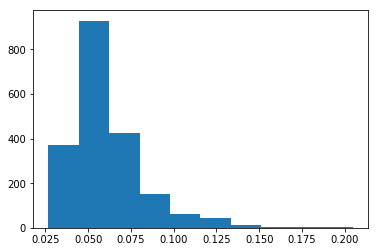

(0.8035,
 0.798,
 [0.01449650526046753,
  0.0006438493728637695,
  0.0005871057510375977,
  0.002245306968688965,
  0.005762040615081787])

In [83]:
S2ti(all_data[5][0], all_data[5][1],all_data[11][0], all_data[11][1], 5, eval_bool = True, dist_eval = True)

In [89]:
%%notify
iterative_scores_5,S2T_scores_5,S2ti_scores_5,dist_list_5 = all_combination_test(5, dist_eval = True)

<IPython.core.display.Javascript object>

In [91]:
dist_S2t1 = [x[0] for x in dist_list_5]
dist_t1t2 = [x[1] for x in dist_list_5]
dist_t2t3 = [x[2] for x in dist_list_5]
dist_t3t4 = [x[3] for x in dist_list_5]
dist_t4t5 = [x[4] for x in dist_list_5]

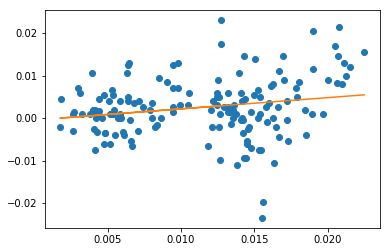

In [94]:
# S2t1
x = np.array(dist_S2t1)
y = np.array(iterative_scores_5)
plt.plot(x,y,'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

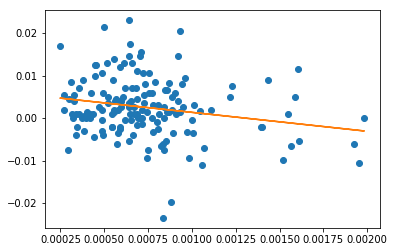

In [95]:
# t1t2
x = np.array(dist_t1t2)
y = np.array(iterative_scores_5)
plt.plot(x,y,'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

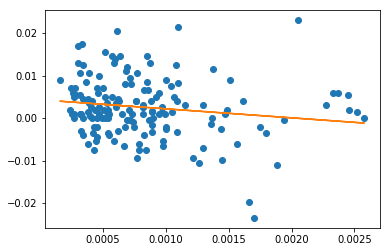

In [96]:
# t2t3
x = np.array(dist_t2t3)
y = np.array(iterative_scores_5)
plt.plot(x,y,'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

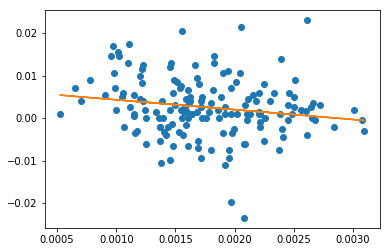

In [97]:
# t3t4
x = np.array(dist_t3t4)
y = np.array(iterative_scores_5)
plt.plot(x,y,'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

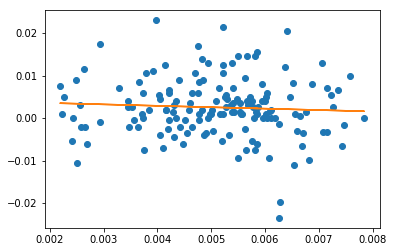

In [98]:
# t4t5
x = np.array(dist_t4t5)
y = np.array(iterative_scores_5)
plt.plot(x,y,'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)